In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent))
import os
os.environ['OMP_NUM_THREADS'] = "1"
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


X_train.shape=(1437, 64)
 1436/1437
calculating p_ij
 1436/1437
calculating fidelity
 1436/1437elapsed time:9.251409100019373


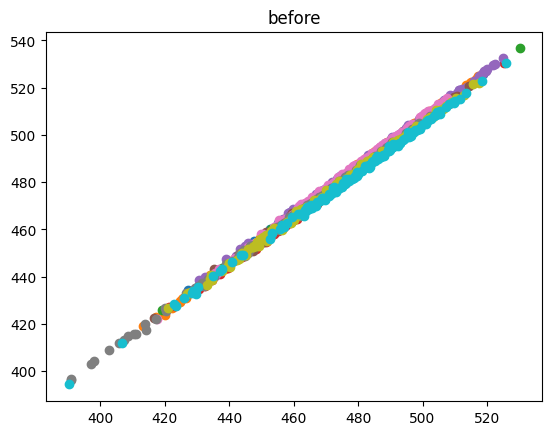

 iter=5000 loss=2.6854105763709275 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 1
     fun: 2.6854116673108104
       x: [-8.479e+02 -4.607e+01 ...  5.534e-01  7.318e-01]
     nit: 0
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 5000


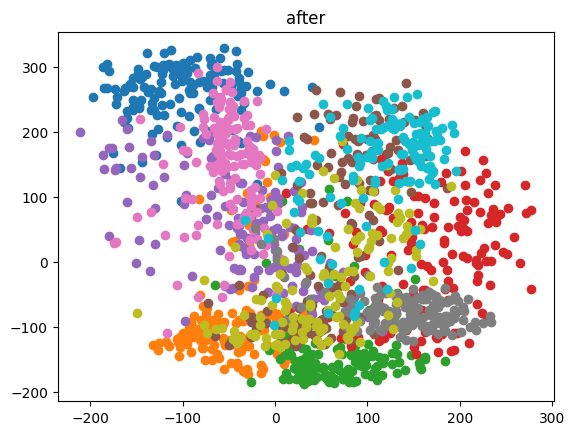

 359/360


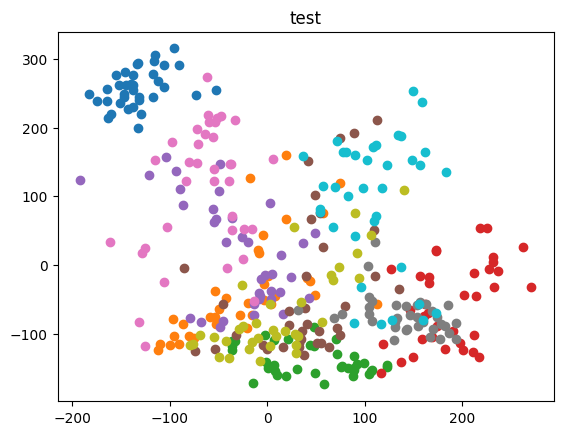

In [2]:
from scikit_quri.qnn.kernel_tsne import quantum_kernel_tsne, pqc_f_helper
import numpy as np
from quri_parts.circuit import H, CZ
from sklearn.datasets import load_iris, load_digits
from sklearn.preprocessing import MinMaxScaler
from scikit_quri.circuit import LearningCircuit
from quri_parts.core.state import quantum_state
from numpy.typing import NDArray
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

def create_quantum_circuit():
    qc = LearningCircuit(n_qubits)

    def preprocess_x(x: NDArray[np.float_], index: int) -> float:
        xa = x[index % len(x)]
        return min(1, max(-1, xa))

    for i in range(n_qubits):
        qc.add_gate(H(i))
    for d in range(depth):
        for i in range(n_qubits):
            qc.add_input_RY_gate(i, lambda x, i=i: preprocess_x(x, i))
        for i in range(n_qubits):
            qc.add_input_RX_gate(i, lambda x, i=i: preprocess_x(x, i))
        if d < depth - 1:
            for i in range(n_qubits):
                qc.add_gate(CZ(i, (i + 1) % n_qubits))
    return qc
# X, Y = load_iris(return_X_y=True)
X,Y = load_digits(return_X_y=True)
X = X / 16.
n_features = 12

skf = StratifiedKFold()
for tr_index, te_index in skf.split(X,Y):
    break


X_train = X[tr_index]
X_test = X[te_index]
y_train = Y[tr_index]
y_test = Y[te_index]
print(f"{X_train.shape=}")

pca = PCA(n_components=n_features)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
# X_train = X_train / 16.
# X_train = X_train[:200]
# y_train = y_train[:200] #500 => fidelity 81.6[s]
scaler = MinMaxScaler((0, np.pi / 2))
n_qubits = 12
depth = 1

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
qk_tsne = quantum_kernel_tsne(max_iter=5000)
X_train_state = np.zeros(len(X_train),dtype=object)
pqc = create_quantum_circuit()
for i,x in enumerate(X_train):
    X_train_state[i] = (quantum_state(n_qubits=n_qubits,circuit=pqc.bind_input_and_parameters(x,[])))
p_probs = (qk_tsne.tsne.calc_probabilities_p_state(X_train_state))
# print(f"{p_probs=}")
qk_tsne.init(create_quantum_circuit, [])
qk_tsne.train(X_train, y_train, method="Powell")

pred_y= (qk_tsne.transform(X_test))
qk_tsne.plot(pred_y, y_test, "test")


In [3]:
from scipy.spatial import distance
# M = np.random.randint(0, 10, (5, 2))
M = np.array([[np.random.rand()] for _ in range(5) ])
cdist = distance.cdist(M,M)
print(cdist)

[[0.         0.25862233 0.00528223 0.33892412 0.2353256 ]
 [0.25862233 0.         0.26390456 0.59754645 0.02329673]
 [0.00528223 0.26390456 0.         0.33364189 0.24060783]
 [0.33892412 0.59754645 0.33364189 0.         0.57424972]
 [0.2353256  0.02329673 0.24060783 0.57424972 0.        ]]


In [4]:
print(f"{M=}")
x1_norm = np.sum(M**2,axis=1)[:,np.newaxis]
print(f"{x1_norm=}")
x1_pad = np.ones_like(x1_norm)
print(f"{x1_norm.shape=}")
print(f"{x1_pad.shape=}")
print(f"{(-2*M).shape=}")
# phi = np.concatenate((-2*M,np.sum(M**2,axis=1),np.ones((len(M),1))))
psi = np.concatenate((-2*M,x1_norm,x1_pad),axis=1)
print(psi)

M=array([[0.52900039],
       [0.78762273],
       [0.52371816],
       [0.19007628],
       [0.764326  ]])
x1_norm=array([[0.27984142],
       [0.62034956],
       [0.27428072],
       [0.03612899],
       [0.58419423]])
x1_norm.shape=(5, 1)
x1_pad.shape=(5, 1)
(-2*M).shape=(5, 1)
[[-1.05800079  0.27984142  1.        ]
 [-1.57524545  0.62034956  1.        ]
 [-1.04743633  0.27428072  1.        ]
 [-0.38015255  0.03612899  1.        ]
 [-1.52865199  0.58419423  1.        ]]


In [5]:
x2_norm = np.sum(M**2,axis=1)[:,np.newaxis]
x2_pad = np.ones_like(x2_norm)
phi = np.concatenate((M,x2_pad,x2_norm),axis=1)
print(phi)

[[0.52900039 1.         0.27984142]
 [0.78762273 1.         0.62034956]
 [0.52371816 1.         0.27428072]
 [0.19007628 1.         0.03612899]
 [0.764326   1.         0.58419423]]


In [6]:
D_2 = psi @ phi.T
D_2 = np.sqrt(D_2)
print(D_2)

[[0.         0.25862233 0.00528223 0.33892412 0.2353256 ]
 [0.25862233 0.         0.26390456 0.59754645 0.02329673]
 [0.00528223 0.26390456 0.         0.33364189 0.24060783]
 [0.33892412 0.59754645 0.33364189 0.         0.57424972]
 [0.2353256  0.02329673 0.24060783 0.57424972 0.        ]]


In [7]:
np.isclose(D_2,cdist)

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [8]:
# import torch
# from inspect import getsource,getfile
# M = np.array([[np.random.rand()] for _ in range(6) ])
# M_t = torch.tensor(M,dtype=torch.float64,requires_grad=True)
# cdist = torch.cdist(M_t,M_t)
# print(f"{getfile(cdist.grad_fn)=}")
# print(f"{dir(cdist.grad_fn)=}")
# s = torch.sum(cdist)
# s.backward()
# print(f"{M_t.grad=}")

In [9]:
# grad